Loading Data
Dataset loaded successfully.

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null    

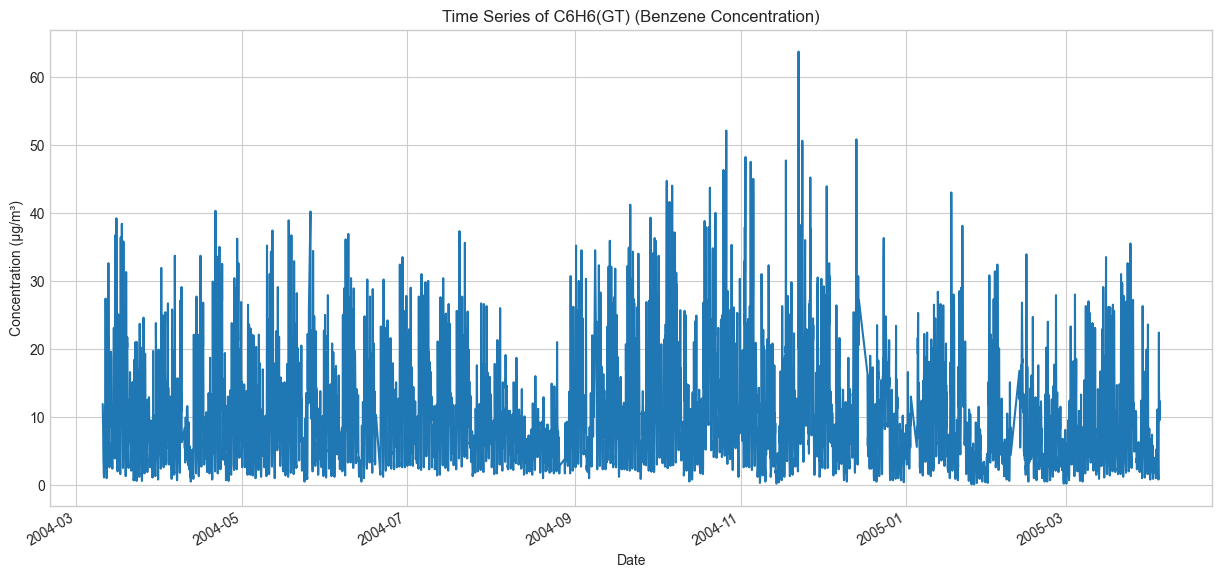

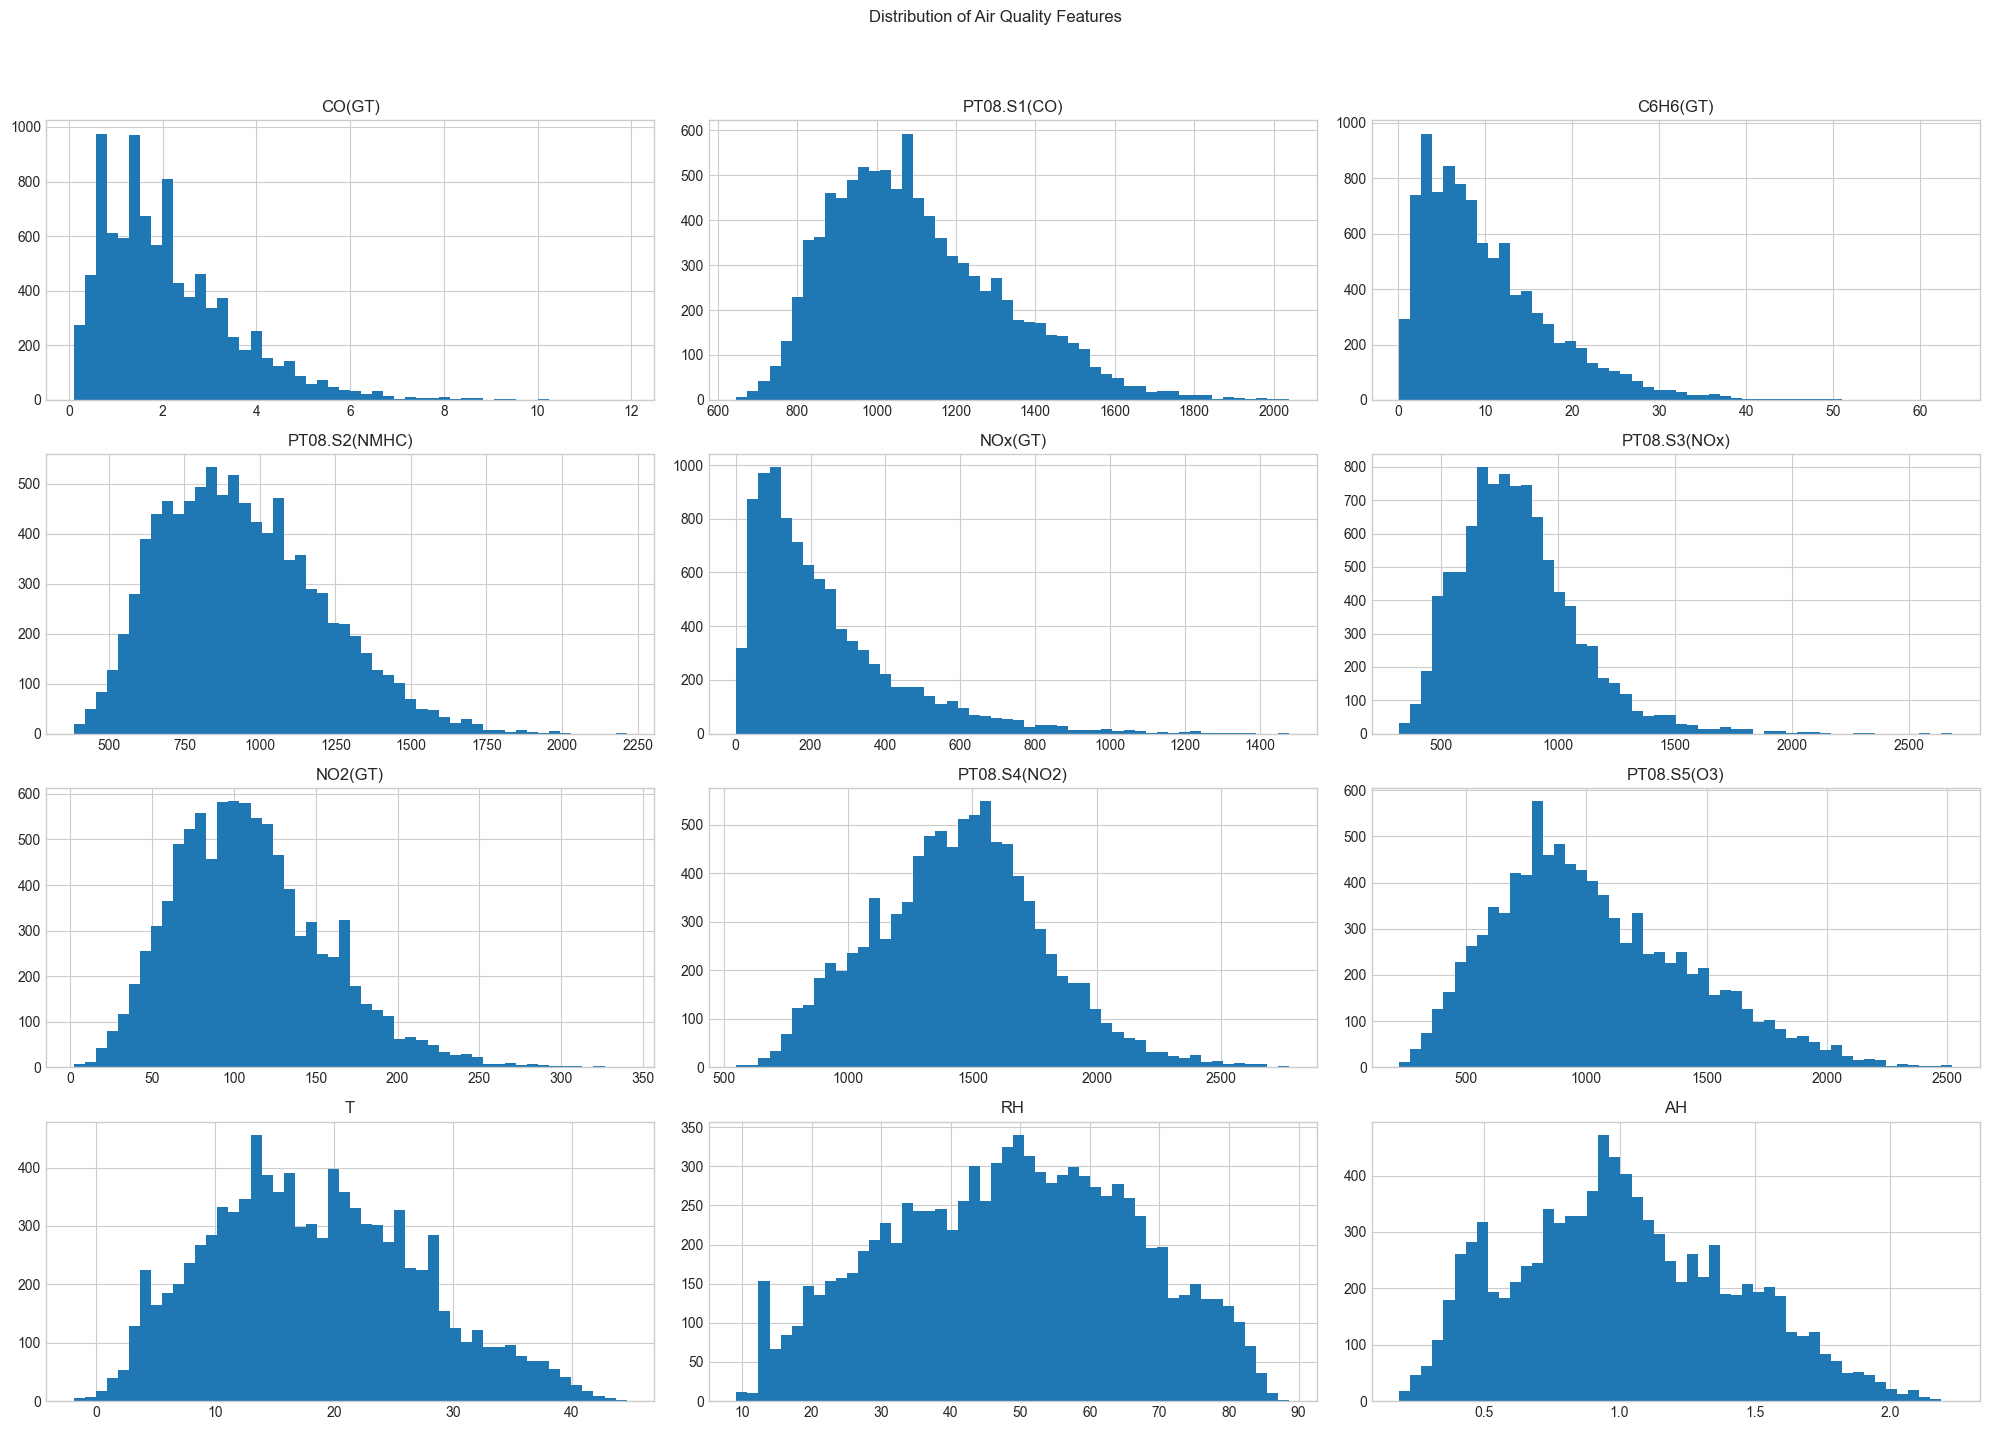

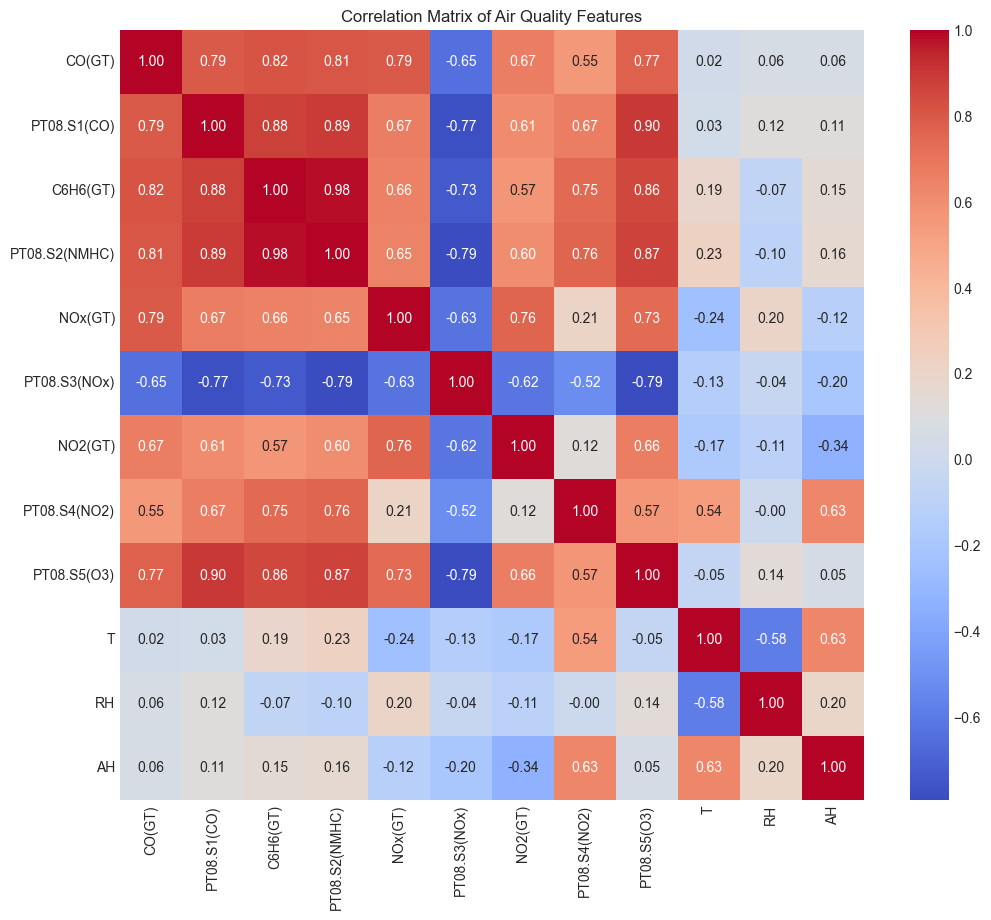


EDA complete. Plots generated.

Performing Feature Engineering

Created time-based features: hour, dayofweek, quarter, month, year, dayofyear.
First 5 rows with new features:
                     CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
DateTime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
DateTime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92

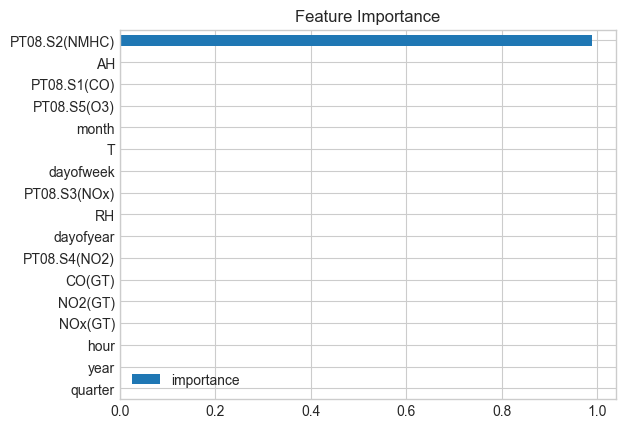

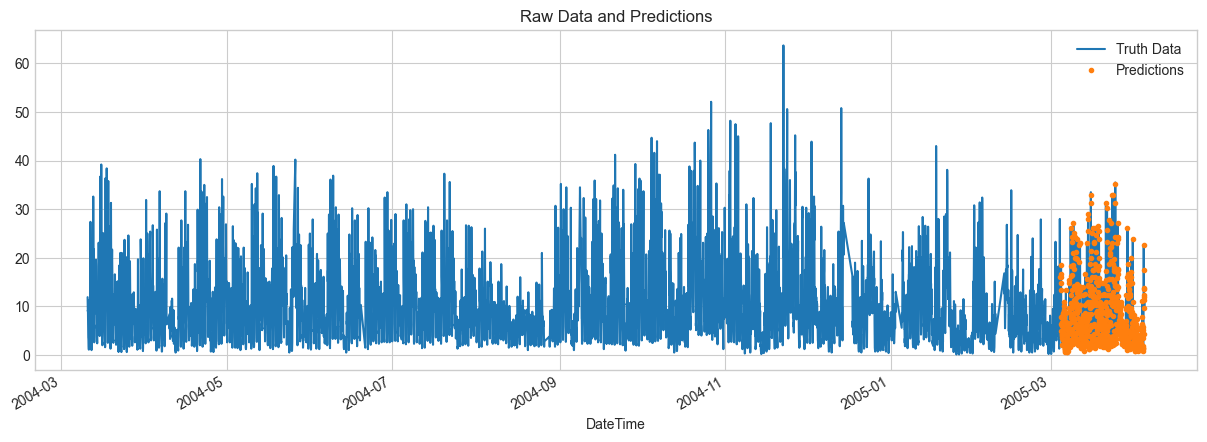

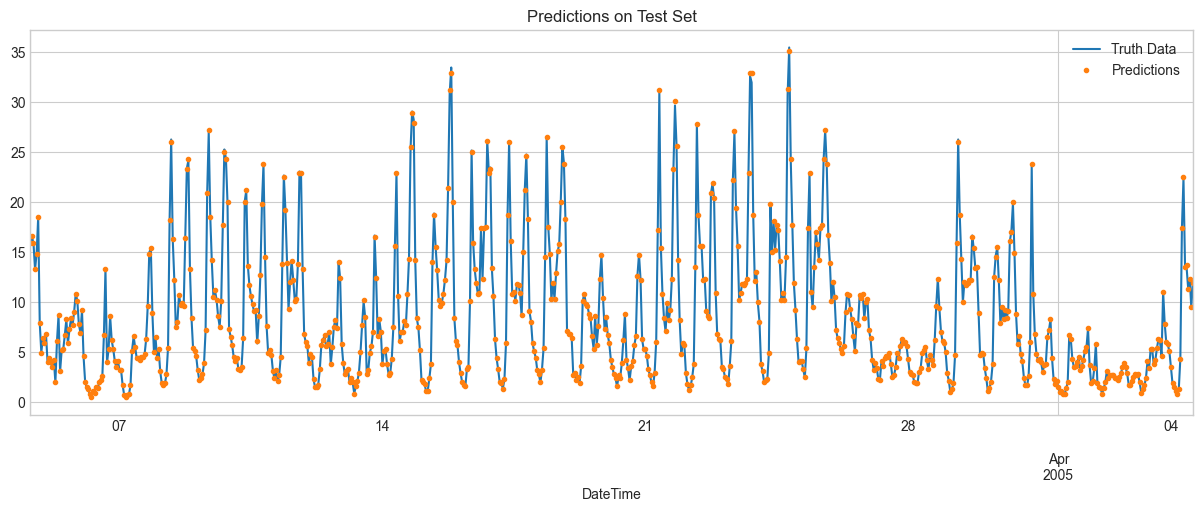

RMSE on Test Set: 0.08
MAE on Test Set: 0.05

The model has been trained and evaluated.


In [ ]:

# Air Quality Index (AQI) Time Series Forecasting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Data Loading 

print("Loading Data")

df = pd.read_csv('/Users/divyachoudhary/Documents/ML_Coursera/AirQuality/AirQualityUCI.csv', sep=';', decimal=',')
print("Dataset loaded successfully.")


# Display initial information about the dataframe
print("\nInitial DataFrame Info:")
df.info()

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nLast 5 rows of the dataset:")
print(df.tail())


# Data Cleaning and Preprocessing

print("\nCleaning and Preprocessing the Data")

# The last two columns are unnamed and full of NaNs, let's drop them.
df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True)

# The dataset uses -200 for missing values. We'll replace them with NaN.
df.replace(to_replace=-200, value=np.nan, inplace=True)

# Combine 'Date' and 'Time' into a single datetime object
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df.set_index('DateTime', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)

# Check for missing values after replacement
print("\nMissing values per column after replacing -200:")
print(df.isnull().sum())

# We can see a lot of missing values. 
# NMHC(GT) has over 90% missing values, so we drop it.
df.drop(columns=['NMHC(GT)'], inplace=True)
print("\nDropped 'NMHC(GT)' column due to excessive missing values.")

# For the other columns, we can use interpolation to fill missing values.
print("\nFilling remaining missing values using linear interpolation...")
for col in df.columns:
    df[col] = df[col].interpolate(method='linear')

# Verify that there are no more missing values
print("\nMissing values after interpolation:")
print(df.isnull().sum())

# Some rows at the end might still have NaNs if they couldn't be interpolated.
df.dropna(inplace=True)
print("\nFinal check for missing values after dropping any remaining NaNs.")
print(df.isnull().sum())
print("\nData cleaning and preprocessing complete.")


# Exploratory Data Analysis

print("\nPerforming Exploratory Data Analysis (EDA)")

# We will focus on 'C6H6(GT)' as our target variable for this project.
target_variable = 'C6H6(GT)'

# Plotting the target variable over time
plt.figure(figsize=(15, 7))
df[target_variable].plot()
plt.title(f'Time Series of {target_variable} (Benzene Concentration)')
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')
plt.show()

# Plotting distributions of all features
df.hist(bins=50, figsize=(20, 15))
plt.suptitle('Distribution of Air Quality Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Air Quality Features')
plt.show()

print("\nEDA complete. Plots generated.")


# Feature Engineering

print("\nPerforming Feature Engineering")

def create_time_features(df):
    """
    Creates time series features from a datetime index.
    """
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_time_features(df)

print("\nCreated time-based features: hour, dayofweek, quarter, month, year, dayofyear.")
print("First 5 rows with new features:")
print(df.head())


# Model Building (XGBoost)

print("\n Building the Forecasting Model")


# Define features (X) and target (y)
FEATURES = ['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)',
            'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH',
            'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = target_variable

X = df[FEATURES]
y = df[TARGET]

# Split the data into training and testing sets
split_date = df.index.max() - pd.DateOffset(months=1)
train = df.loc[df.index <= split_date]
test = df.loc[df.index > split_date]

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Create and train the XGBoost model
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    learning_rate=0.01,
    objective='reg:squarederror',
    eval_metric='rmse'
)

print("\nTraining the XGBoost model...")
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100) 

print("\nModel training complete")


# Model Evaluation 

print("\nStep 6: Evaluating the Model")

# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Make predictions on the test set
test['prediction'] = reg.predict(X_test)

# Plot predictions vs actuals
ax = df[[TARGET]].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

ax = df.loc[df.index > split_date][TARGET].plot(figsize=(15, 5))
test.loc[test.index > split_date]['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Predictions on Test Set')
plt.show()

# Calculate evaluation metrics
score = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
mae = mean_absolute_error(test[TARGET], test['prediction'])
print(f"RMSE on Test Set: {score:0.2f}")
print(f"MAE on Test Set: {mae:0.2f}")

print("\nThe model has been trained and evaluated.")
